## Import Libraries

In [6]:
import GetTesouroDiretoData as gtd
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

## Download Tesouro Direto Dataset

In [2]:
gtd.TesouroDiretoDatasets().download_all_data('TesouroDireto')

## Data Analysis

In [2]:
operacoes = pd.read_parquet('TesouroDireto_operacoes.parquet')
investidores = pd.read_parquet('TesouroDireto_investidores.parquet')
taxas = pd.read_parquet('TesouroDireto_taxas.parquet')
vendas = pd.read_parquet('TesouroDireto_vendas.parquet')
estoque = pd.read_parquet('TesouroDireto_estoque.parquet')

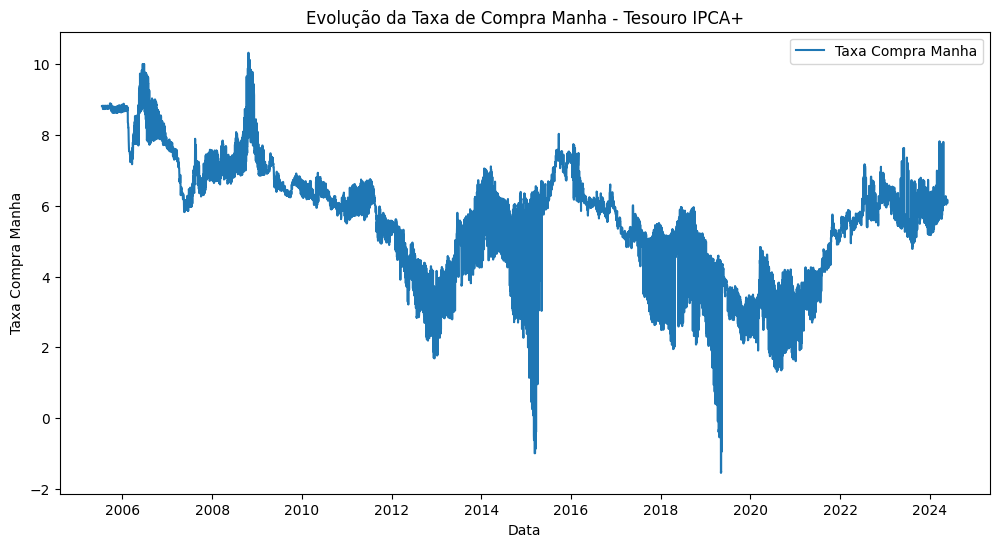

In [20]:
taxas['Data Base'] = pd.to_datetime(taxas['Data Base'])

# Filtrar os dados para o título "Tesouro IPCA+"
tesouro_ipca = taxas[taxas['Tipo Titulo'] == 'Tesouro IPCA+']

# Criar uma série temporal para 'Taxa Compra Manha'
ts = tesouro_ipca.set_index('Data Base')['Taxa Compra Manha'].sort_index()

# Remover datas duplicadas, mantendo a última ocorrência
ts = ts[~ts.index.duplicated(keep='last')]

# Definir a frequência da série temporal
# Preencher valores faltantes para garantir uma frequência regular
ts = ts.asfreq('D').ffill()

# Plotar a série temporal para visualização inicial
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Taxa Compra Manha')
plt.title('Evolução da Taxa de Compra Manha - Tesouro IPCA+')
plt.xlabel('Data')
plt.ylabel('Taxa Compra Manha')
plt.legend()
plt.show()

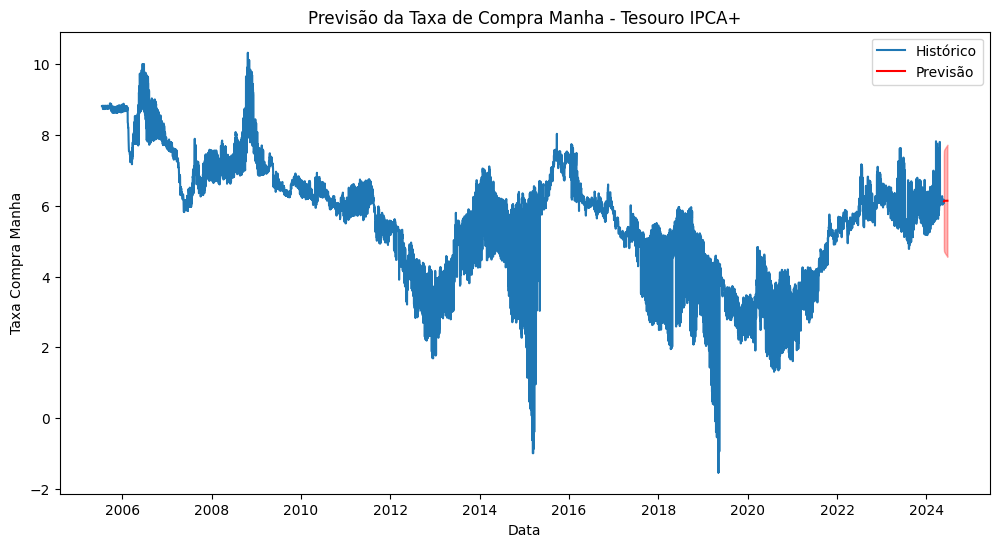

In [26]:
# Converter 'Data Base' para datetime
taxas['Data Base'] = pd.to_datetime(taxas['Data Base'])

# Filtrar os dados para o título "Tesouro IPCA+"
tesouro_ipca = taxas[taxas['Tipo Titulo'] == 'Tesouro IPCA+']

# Criar uma série temporal para 'Taxa Compra Manha'
ts = tesouro_ipca.set_index('Data Base')['Taxa Compra Manha'].sort_index()

# Remover datas duplicadas, mantendo a última ocorrência
ts = ts[~ts.index.duplicated(keep='last')]

# Definir a frequência da série temporal
# Preencher valores faltantes para garantir uma frequência regular
ts = ts.asfreq('D').ffill()

# Ajuste do modelo ARIMA
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

# Fazer previsões para os próximos 30 dias
forecast = model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(start=ts.index[-1], periods=30, freq='D')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
forecast_ci = forecast.conf_int()

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Histórico')
plt.plot(forecast_series, label='Previsão', color='red')
plt.fill_between(forecast_series.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.3)
plt.title('Previsão da Taxa de Compra Manha - Tesouro IPCA+')
plt.xlabel('Data')
plt.ylabel('Taxa Compra Manha')
plt.legend()
plt.show()